<a href="https://www.kaggle.com/code/jackcarlisle24/75speciesbutterflyclassification?scriptVersionId=208213001" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import torch
import numpy as np 
import pandas as pd 
import csv 
import os 
import torch.nn as nn 
import torch.optim as optim 
import imageio 
import matplotlib.pyplot as plt 
import torchvision 
from torchvision import transforms 
import gc

print('Working Directory: '+ os.getcwd())

device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')) 
print('Device: '+ str(device))

Working Directory: /kaggle/working
Device: cuda


# Introduction

Image classification in machine learning refers to the problem of assigning labels to images. One of the most effective models for solving image classification problems is the convolutional neural network, which is a variation of an ordinary or fully connected neural network. In this notebook, we will build a convolutional neural network which classify butterfly species. More precisely, we have a dataset consisting of images of butterflies of 75 different species, and we will build a convolutional neural network which predicts the species of a given input image.

# The Dataset

We begin by investigating our dataset and preparing it for training. The file "Training_set.csv" consists of 6499 tuples (filename, species), of the filename of one of our butterfly images, and the corresponding label of its species.

In [2]:
data = pd.read_csv('/kaggle/input/butterflydataset/butterflydata/Training_set.csv')
data.head()

filename                     label
0  Image_1.jpg          SOUTHERN DOGFACE
1  Image_2.jpg                    ADONIS
2  Image_3.jpg            BROWN SIPROETA
3  Image_4.jpg                   MONARCH
4  Image_5.jpg  GREEN CELLED CATTLEHEART

Let's take a look at a few of our images.

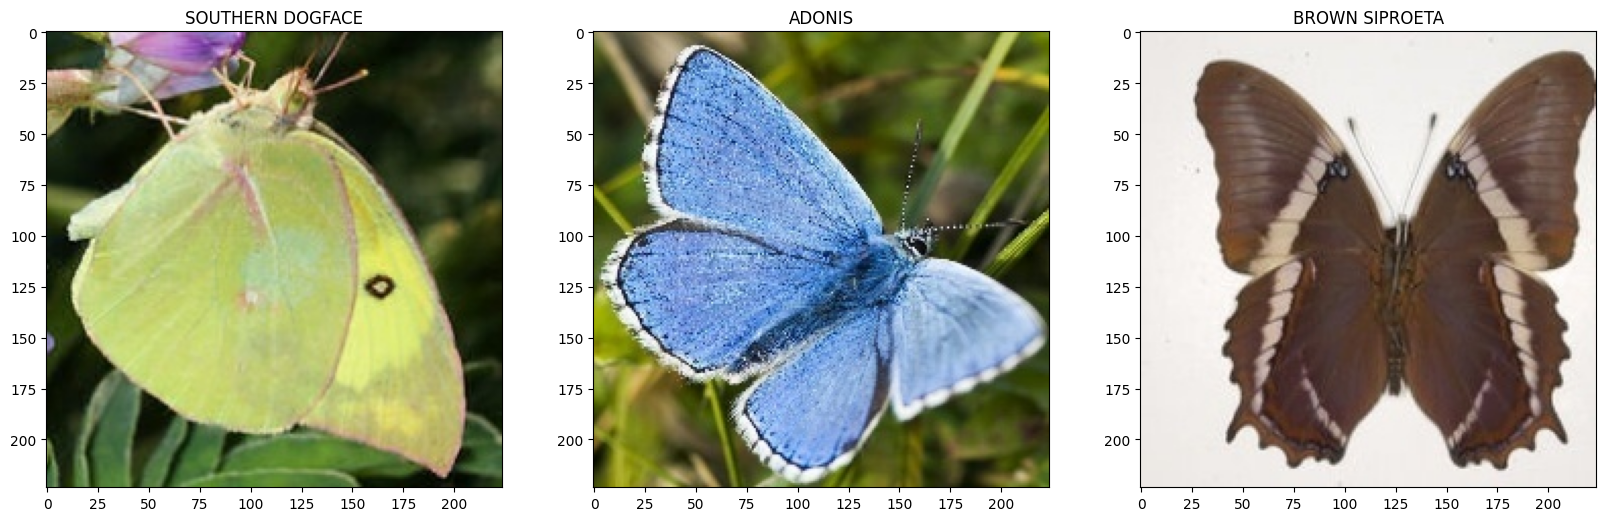

In [3]:
f,ax = plt.subplots(1,3,figsize = (20,10))

for i in range(3):
    image = imageio.v2.imread('/kaggle/input/butterflydataset/butterflydata/train/Image_'+str(i+1)+'.jpg')
    ax[i].imshow(image)
    ax[i].set_title(data.iloc[i]['label'])

plt.savefig('sample_images.png')
plt.show()

In order to train our model, we need to convert our data into a useful format. Altogether, our dataset consists of 6499 images, each of which has 3 channels (RGB), and has size 224 x 224. We convert this data into a tensor X of size (6499,3,244,244). We then create a target tensor y of size (6499), where each entry is an integer between 0 and 74, which corresponds to one of the 75 possible butterfly species in our data set.

In [4]:
X = torch.zeros(len(data), 3, 224, 224, dtype=torch.uint8)

directory = '/kaggle/input/butterflydataset/butterflydata/train/'
filenames = [name for name in data['filename']
              if os.path.splitext(name)[-1] == '.jpg']

for i, filename in enumerate(filenames):
  img_arr = imageio.v2.imread(os.path.join(directory, filename))
  img = torch.from_numpy(img_arr)
  img = img.permute(2,0,1)
  img = img[:3]
  X[i] = img

X = X.float().to(device)
X = transforms.Normalize(X.view(3,-1).mean(dim = 1), X.view(3,-1).std(dim = 1))(X)

species_to_int = {}
i=0
for k in range(0,len(data)):
    if data.iloc[k]['label'] not in species_to_int.keys():
        species_to_int[data.iloc[k]['label']] = i
        i += 1
        
y = [species_to_int[data.iloc[i]['label']] for i in range(len(data['label']))]
y = torch.tensor(y)
y = y.to(device)


X.shape, y.shape

(torch.Size([6499, 3, 224, 224]), torch.Size([6499]))

Next we split our dataset of 6499 samples into a training set of size 5199 and a testing set of size 1300. We then create a dataset and dataloader for our training data and our testing data. We also create a sequence of transforms for data augmentation, which we will explicate in the next section.

In [5]:
import sklearn
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 0,
                                                    shuffle = True)

class ButterflyDataset(torch.utils.data.Dataset):

  def __init__(self,X,y, transform = None):
    self.X = X
    self.y = y
    self.transform = transform

  def __getitem__(self, index):
    return self.transform(self.X[index]), self.y[index]

  def __len__(self):
    return len(self.X)

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
])

data_train = ButterflyDataset(X_train,y_train, transform = train_transforms)
data_test = ButterflyDataset(X_test,y_test)

from torch.utils.data import DataLoader

train_loader = DataLoader(data_train, batch_size = 8, shuffle = True)
test_loader = DataLoader(data_test, batch_size = 8, shuffle = True)


X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([5199, 3, 224, 224]),
 torch.Size([1300, 3, 224, 224]),
 torch.Size([5199]),
 torch.Size([1300]))

# Data Augmentation

In order to optimize the performance of our model, we will implement data augmentation techniques. The idea is that, by creating transformed versions of our input images, we can artificially increase the size of our training set. This allows our model to "see" more instances of each butterfly species, which will increase its performance on previously unseen images. Our transforms will include horizontal flips, vertical flips, and rotations. Each of these is applied randomly (with some fixed probability) to the images in our training set during training. In order to visualize the effect of these transformations, we plot several original images, next to their transformed counterparts.

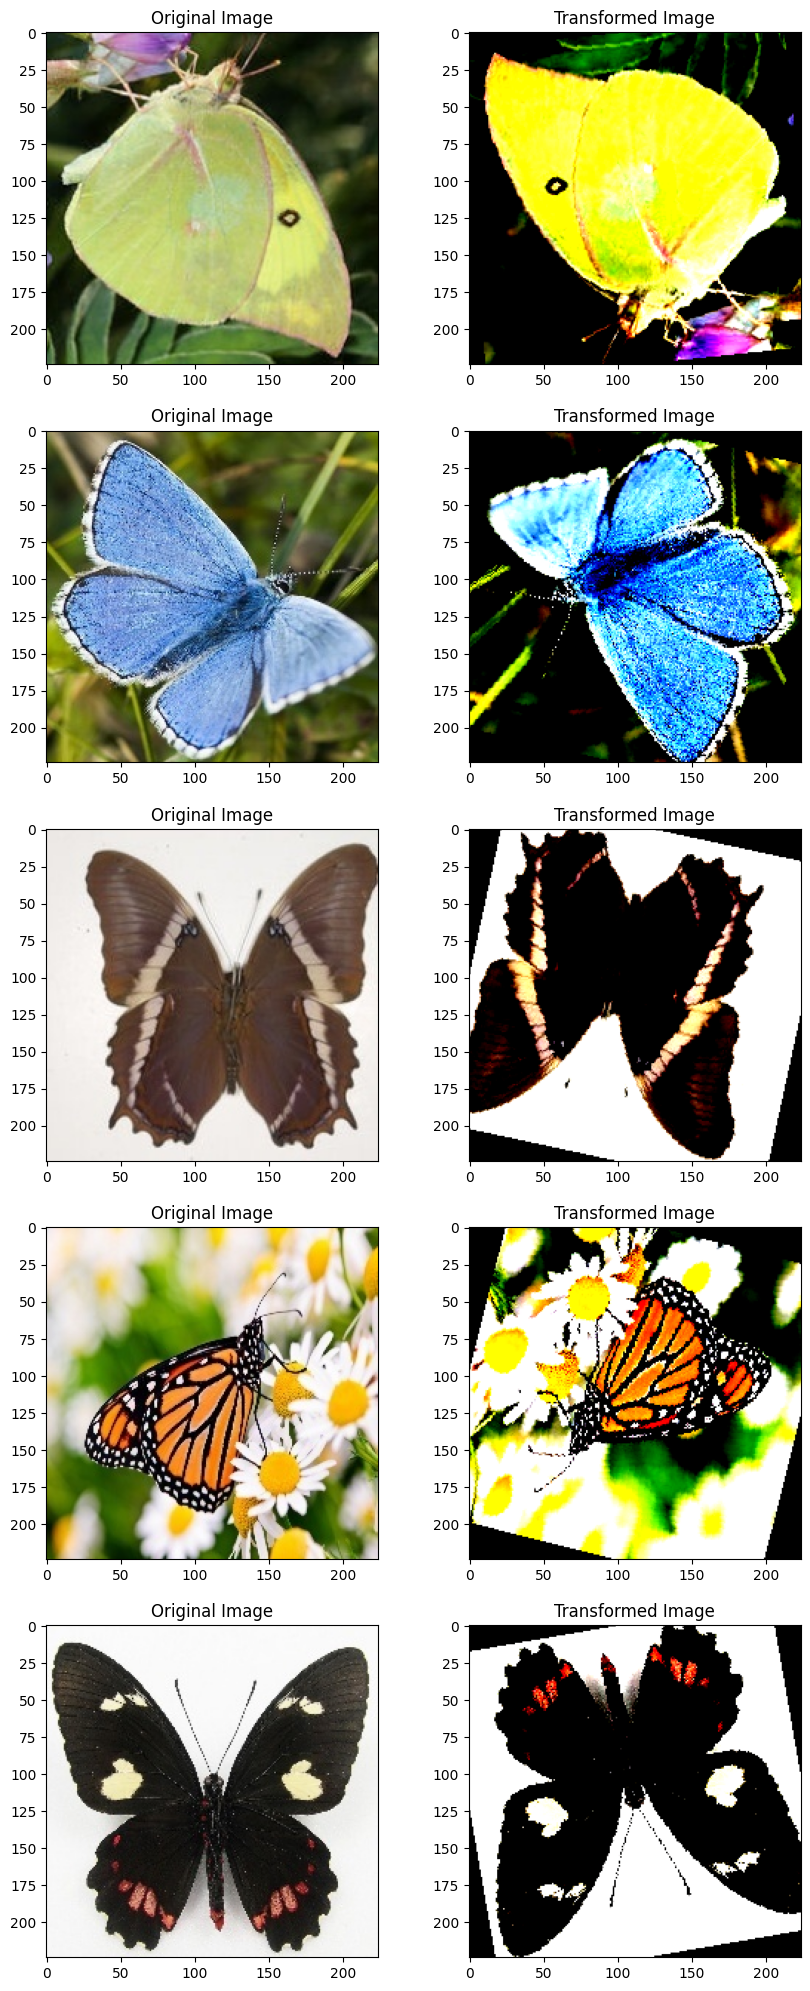

In [6]:
example_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(1),
    transforms.RandomVerticalFlip(1),
    transforms.RandomRotation(15),
])

f,ax = plt.subplots(5,2,figsize = (10,25))

for i in range(5):
    ax[i,0].imshow(imageio.v2.imread('/kaggle/input/butterflydataset/butterflydata/train/Image_'+str(i+1)+'.jpg'))
    ax[i,0].set_title('Original Image')
    ax[i,1].imshow(example_transforms(X[i]).permute(1,2,0).cpu().numpy())
    ax[i,1].set_title('Transformed Image')
plt.savefig('augmented_images.png')
plt.show()
plt.close()

Note that the difference in coloration between the original and transformed images is caused by the normalization we performed on all images of our training set. 

# Constructing and training our neural network

Having fully prepared out training and testing data, we construct our neural network. Our network consists of 8 convolutional layers, followed by a single fully connected layer. Each convolutional layer consists of 3 parts. The first part is a convolution operation, which applies a collection of (number of output channels) convolution kernels of size (number of input channels)x5x5 to the input. The second part is a batch norm, which normalizes the output data of the convolutional layer. The third part is a (non-linear) activation function, namely the rectified linear unit ReLU, which acts by x -> max(x,0). 

In [7]:
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential()
        self.layer1.add_module('conv1',nn.Conv2d(3, 4, kernel_size = 5, padding = 2))
        self.layer1.add_module('bn1',nn.BatchNorm2d(4))
        self.layer1.add_module('relu1', nn.ReLU(inplace=False))
        self.layer2 = nn.Sequential()
        self.layer2.add_module('conv2',nn.Conv2d(4, 8, kernel_size = 5, padding = 2))
        self.layer2.add_module('bn2',nn.BatchNorm2d(8))
        self.layer2.add_module('relu2', nn.ReLU(inplace=False))
        self.layer3 = nn.Sequential()
        self.layer3.add_module('conv3',nn.Conv2d(8, 16, kernel_size = 5, padding = 2))
        self.layer3.add_module('bn3',nn.BatchNorm2d(16))
        self.layer3.add_module('relu3', nn.ReLU(inplace=False))
        self.layer4 = nn.Sequential()
        self.layer4.add_module('conv4',nn.Conv2d(16, 32, kernel_size = 5, padding = 2))
        self.layer4.add_module('bn4',nn.BatchNorm2d(32))
        self.layer4.add_module('relu4', nn.ReLU(inplace=False))
        self.layer5 = nn.Sequential()
        self.layer5.add_module('conv5',nn.Conv2d(32, 64, kernel_size = 5, padding = 2))
        self.layer5.add_module('bn5',nn.BatchNorm2d(64))
        self.layer5.add_module('relu5', nn.ReLU(inplace=False))
        self.layer6 = nn.Sequential()
        self.layer6.add_module('conv6', nn.Conv2d(64,128, kernel_size = 5, padding = 2))
        self.layer6.add_module('bn6', nn.BatchNorm2d(128))
        self.layer6.add_module('relu6', nn.ReLU(inplace = False))
        self.layer7 = nn.Sequential()
        self.layer7.add_module('conv7', nn.Conv2d(128,256, kernel_size = 5, padding = 2))
        self.layer7.add_module('bn7', nn.BatchNorm2d(256))
        self.layer7.add_module('relu7', nn.ReLU(inplace = False))
        self.layer8 = nn.Sequential()
        self.layer8.add_module('conv8', nn.Conv2d(256,512, kernel_size = 5, padding = 2))
        self.layer8.add_module('bn8', nn.BatchNorm2d(512))
        self.layer8.add_module('relu8', nn.ReLU(inplace = False))
        self.fc1 = nn.Linear(512*1*1, 75)

    def forward(self, x):
        out = F.max_pool2d(self.layer1(x), kernel_size = 2)
        out = F.max_pool2d(self.layer2(out), kernel_size = 2)
        out = F.max_pool2d(self.layer3(out), kernel_size = 2)
        out = F.max_pool2d(self.layer4(out), kernel_size = 2)
        out = F.max_pool2d(self.layer5(out), kernel_size = 2)
        out = F.max_pool2d(self.layer6(out),padding = 1, kernel_size = 2)
        out = F.max_pool2d(self.layer7(out), kernel_size = 2)
        out = F.max_pool2d(self.layer8(out), kernel_size = 2)
        out = out.view(-1, 512*1*1)
        out = self.fc1(out)
        return out

model = CNN()
model = model.to(device)

Next, we prepare for training by defining a training loop "training_loop". 

In [8]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader,val_loader=None):
  for epoch in range(1,n_epochs+1):
    loss_train = 0.0
    for inputs, labels in train_loader:
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_train += loss.item()
    if epoch ==1 or epoch % 10 == 0:
        print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, loss_train/len(train_loader)))

Finally, we train our model on our training data.

In [9]:
training_loop(
    n_epochs = 100,
    optimizer = optim.SGD(model.parameters(), lr = 0.01),
    model = model,
    loss_fn = nn.CrossEntropyLoss(),
    train_loader = train_loader
)

2024-11-18 17:10:37.236707 Epoch 1, Training loss 3.603338349782504
2024-11-18 17:12:20.220958 Epoch 10, Training loss 1.1089106574196081
2024-11-18 17:14:15.482488 Epoch 20, Training loss 0.5939752776920796
2024-11-18 17:16:10.449064 Epoch 30, Training loss 0.3008936886639836
2024-11-18 17:18:05.597546 Epoch 40, Training loss 0.1923862765895991
2024-11-18 17:20:00.828523 Epoch 50, Training loss 0.113929654645841
2024-11-18 17:21:55.920461 Epoch 60, Training loss 0.07978499357024423
2024-11-18 17:23:51.110680 Epoch 70, Training loss 0.05860893416601287
2024-11-18 17:25:46.232431 Epoch 80, Training loss 0.04519755226089798
2024-11-18 17:27:41.628924 Epoch 90, Training loss 0.027593448136344356
2024-11-18 17:29:37.279165 Epoch 100, Training loss 0.026638992488285742


# Testing our model

Now that our model has been trained, let's see how well it performs on the testing set.

In [10]:
model = model.to('cpu')
y_pred = torch.argmax(nn.Softmax(dim=1)(model(X_test.to('cpu'))), dim=1)
correct_preds = (y_pred == y_test.to('cpu')).float()
accuracy = correct_preds.mean().numpy()*100

print('Model Accuracy = '+ str(accuracy) + '%')

Model Accuracy = 81.38461709022522%


Our model has an accuracy of about 83%. We can get further insight into the performance of our model by plotting a confusion matrix.

<function matplotlib.pyplot.show(close=None, block=None)>

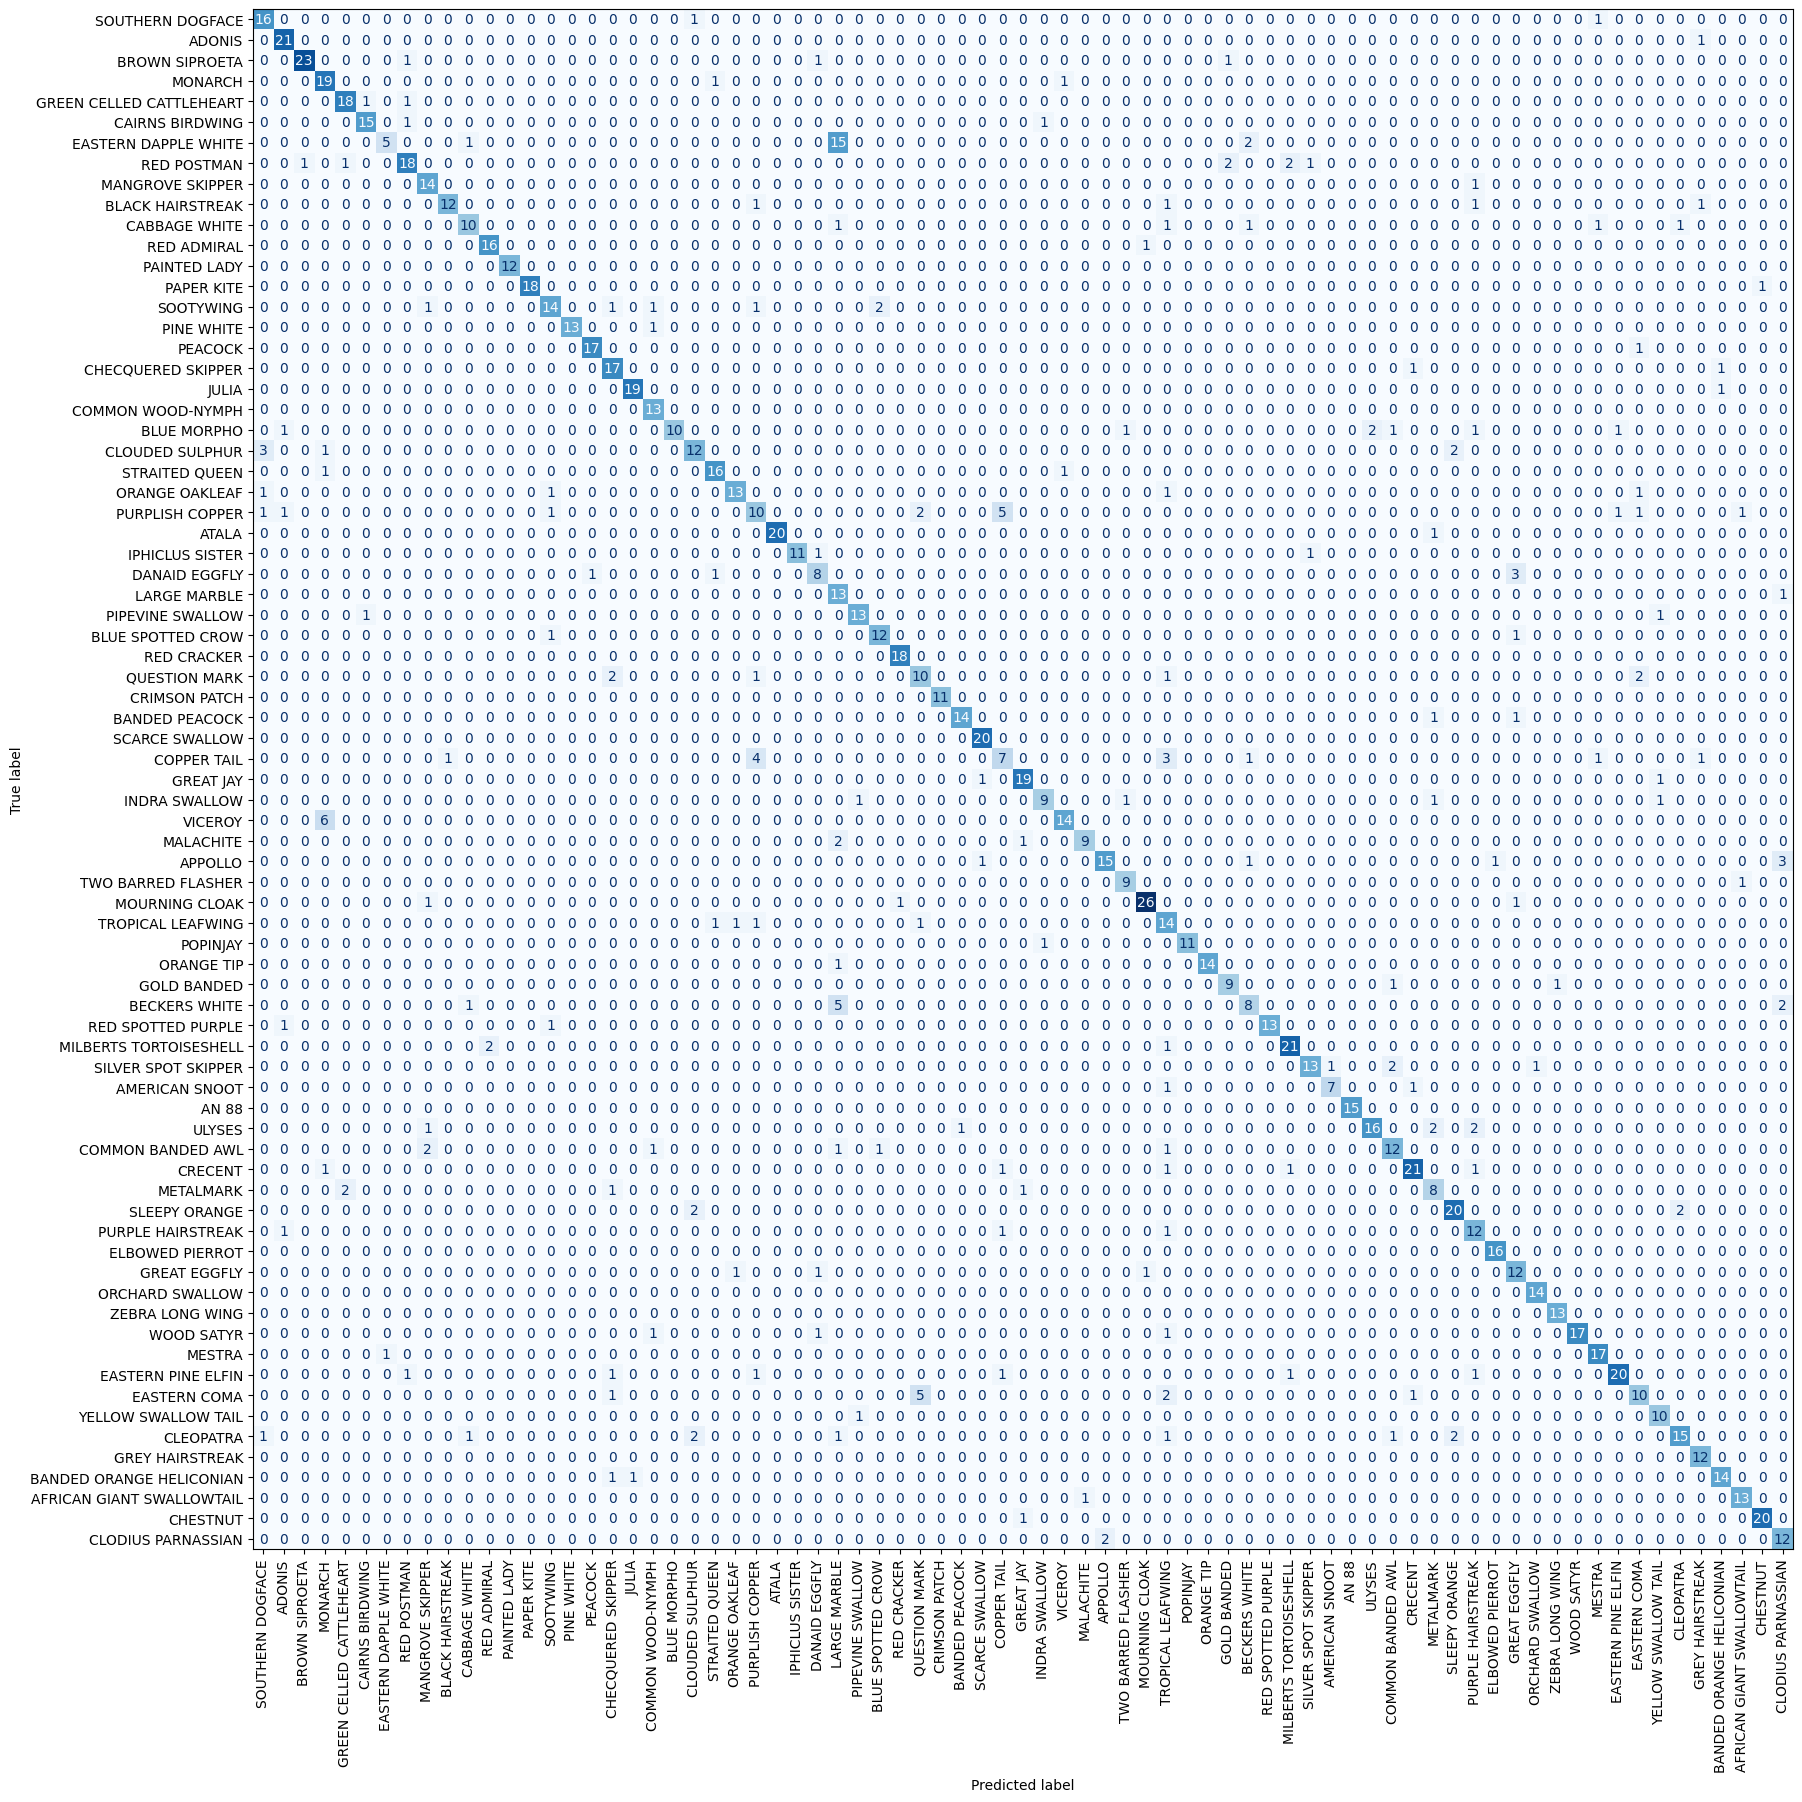

In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

f,ax = plt.subplots(1,1,figsize=(20,20))
ConfusionMatrixDisplay.from_predictions(y_test.to('cpu'), y_pred, ax=ax, cmap = 'Blues', colorbar = False, display_labels = species_to_int.keys())
plt.xticks(rotation = 90)
plt.savefig('confusion_matrix.png')
plt.show


<function matplotlib.pyplot.close(fig=None)>

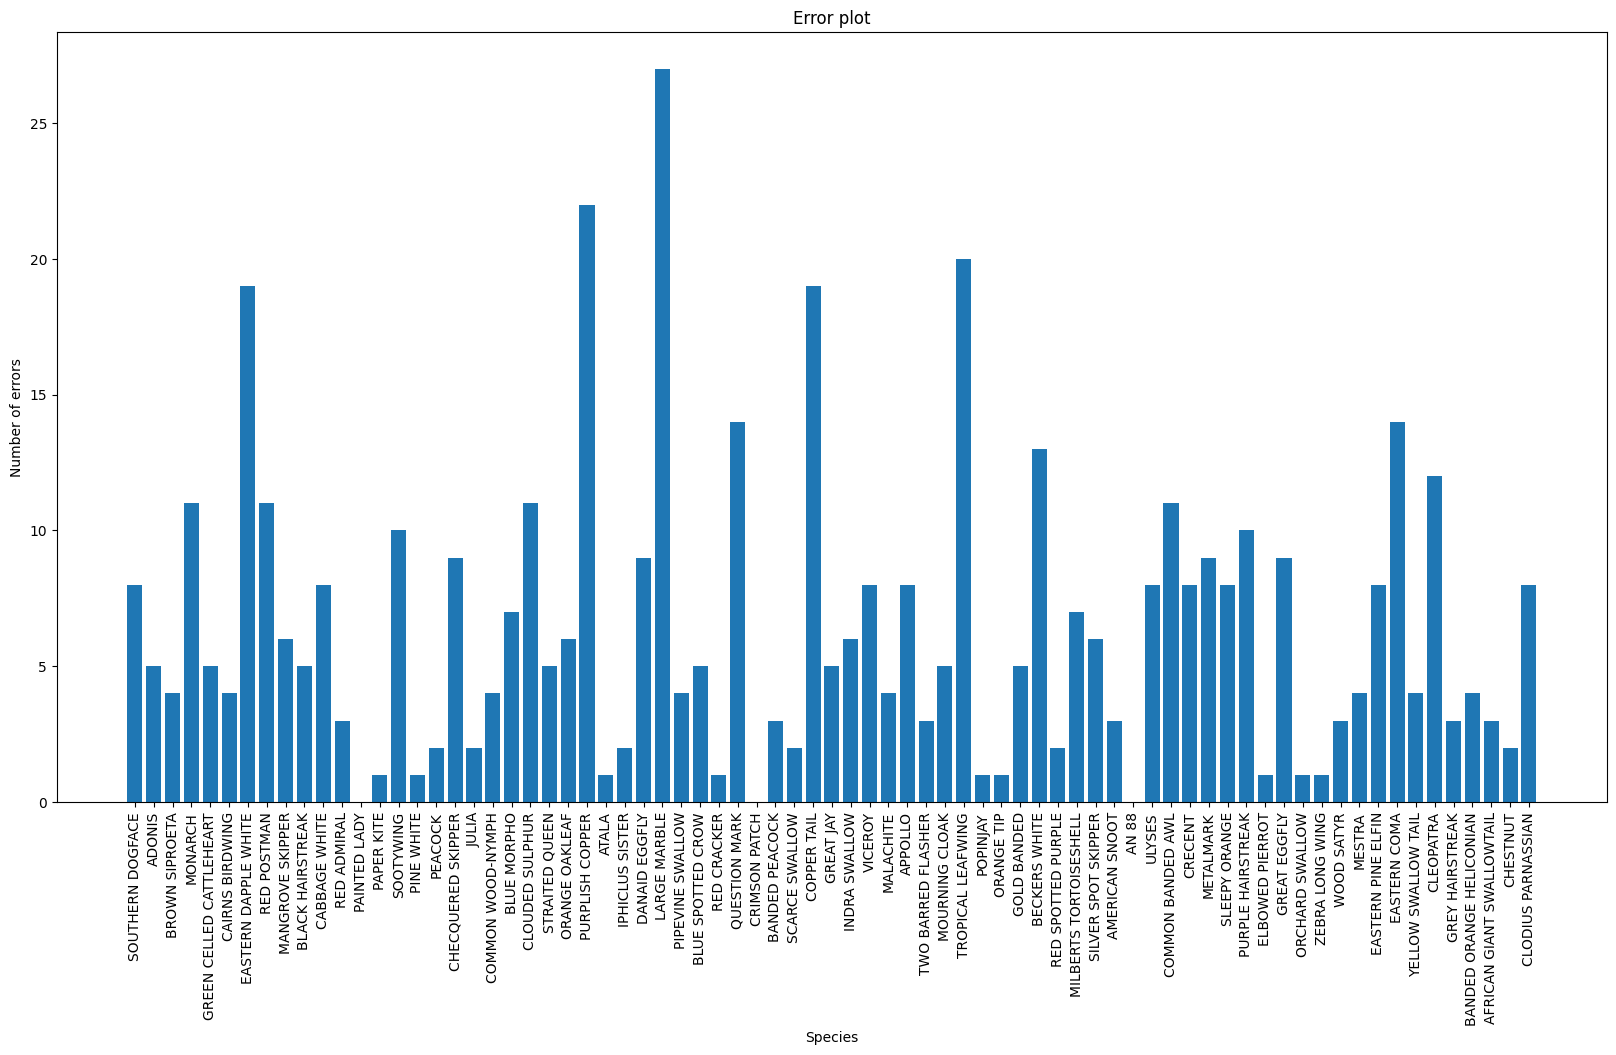

In [12]:
cm = confusion_matrix(y_pred,y_test.to('cpu'))

errors = {}
for n in range(75):
    errors[n] = 0
    for i in range(75):
        if i != n:
            errors[n] += cm[n][i]
            errors[n] +=cm[i][n]

plt.figure(figsize = (20,10))
plt.bar(species_to_int.keys(),errors.values())
plt.title('Error plot')
plt.xlabel('Species')
plt.xticks(rotation = 90)
plt.ylabel('Number of errors')
plt.show
plt.close


We see that there are a few problematic species, which our model fails to predict as accuractely as the others. For example, our model often confuses 'EASTERN COMA' and 'QUESTION MARK'. It also often confuses 'LARGE MARBLE' and 'EASTERN DAPPLE WHITE'. By taking a look at some images of these species, we see that this is a rather forgiveable mistake, as these species are nearly indistinguishable to the non-expert.

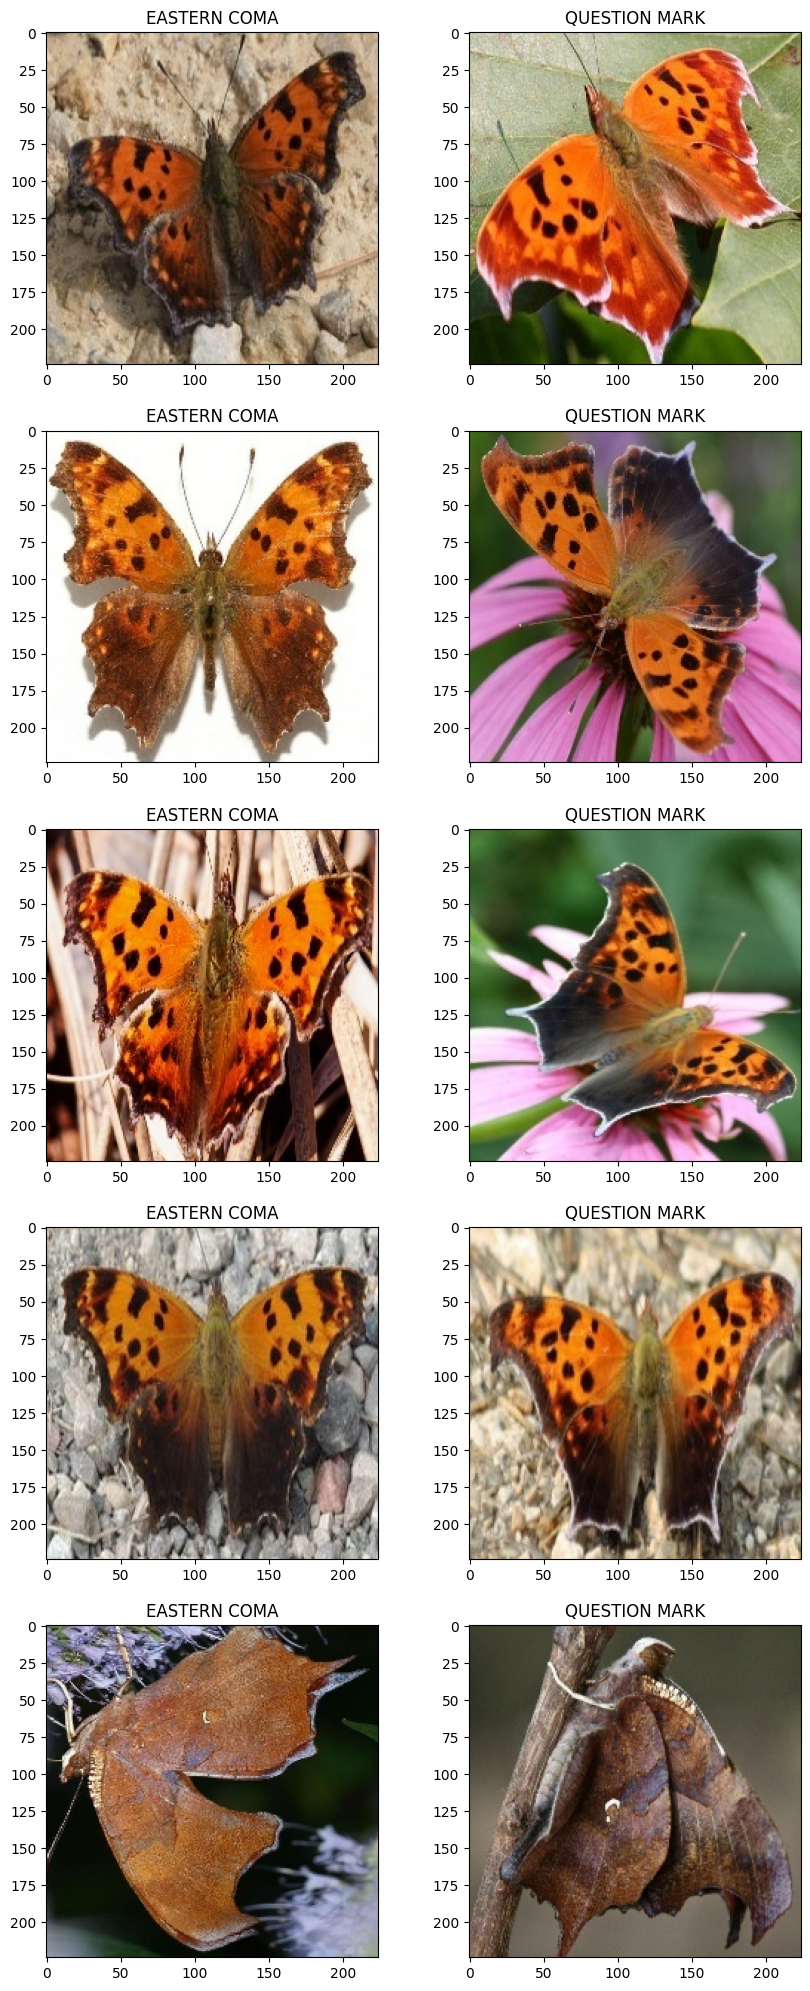

In [13]:
f,ax = plt.subplots(5,2, figsize = (10,25))

ec_count = 0
i=0
while ec_count <5:
    if data.iloc[i]['label'] == 'EASTERN COMA':
        image = imageio.v2.imread('/kaggle/input/butterflydataset/butterflydata/train/Image_'+str(i+1)+'.jpg')
        ax[ec_count,0].imshow(image)
        ax[ec_count,0].set_title('EASTERN COMA')
        ec_count +=1
    i+=1 

qm_count = 0
i=0
while qm_count <5:
    if data.iloc[i]['label'] == 'QUESTION MARK':
        image = imageio.v2.imread('/kaggle/input/butterflydataset/butterflydata/train/Image_'+str(i+1)+'.jpg')
        ax[qm_count,1].imshow(image)
        ax[qm_count,1].set_title('QUESTION MARK')
        qm_count +=1
    i+=1 

plt.savefig('eastern_coma_question_mark_comparison.png')
plt.show()

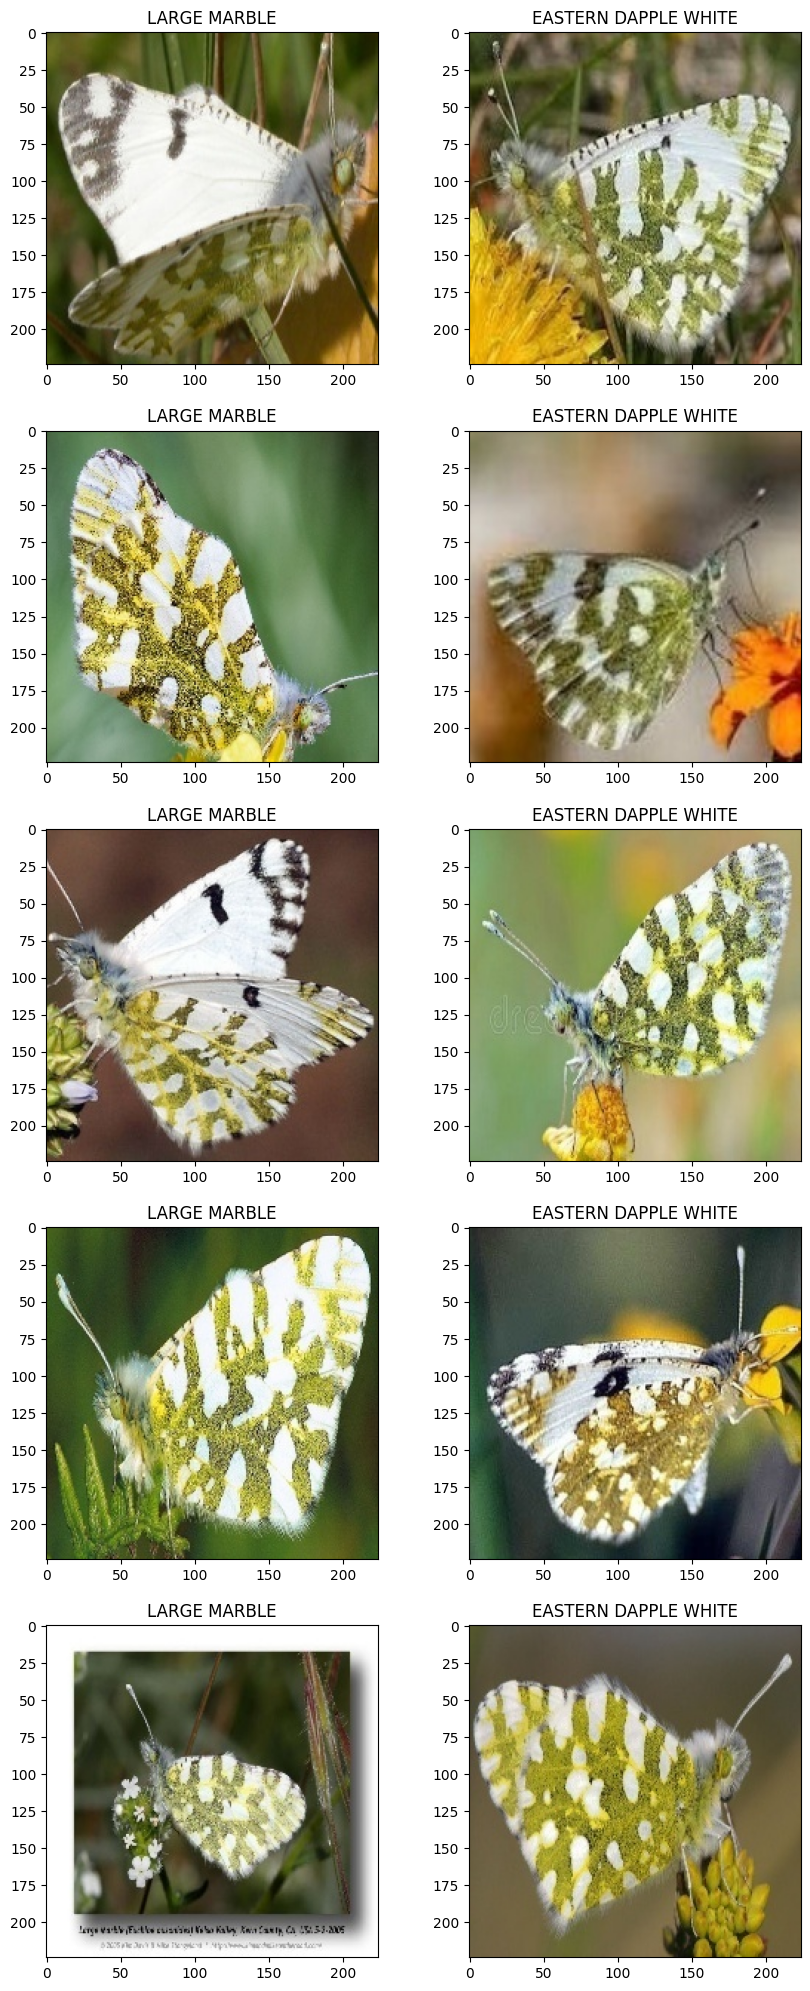

In [14]:
f, ax = plt.subplots(5,2, figsize = (10,25))

lm_count = 0
i=4000
while lm_count <5:
    if data.iloc[i]['label'] == 'LARGE MARBLE':
        image = imageio.v2.imread('/kaggle/input/butterflydataset/butterflydata/train/Image_'+str(i+1)+'.jpg')
        ax[lm_count,0].imshow(image)
        ax[lm_count,0].set_title('LARGE MARBLE')
        lm_count +=1
    i+=1 

edw_count = 0
i=4000
while edw_count <5:
    if data.iloc[i]['label'] == 'EASTERN DAPPLE WHITE':
        image = imageio.v2.imread('/kaggle/input/butterflydataset/butterflydata/train/Image_'+str(i+1)+'.jpg')
        ax[edw_count,1].imshow(image)
        ax[edw_count,1].set_title('EASTERN DAPPLE WHITE')
        edw_count +=1
    i+=1 

plt.savefig('large_marble_eastern_dapple_white_comparison.png')
plt.show()

# Conclusion

Our convolutional neural network achieved an accuracy of about 83% on our training set. Moreover, the erroneous predictions made by the model were fairly forgiveable, as the incorrect predictions it made were mostly between nearly identical species.